In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
import pandas as pd
from transformers import ViTModel
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device='cpu'

In [2]:
# -----------------------
# Cross-Attention Block
# -----------------------
class CrossAttentionBlock(nn.Module):
    def __init__(self, dim_q, dim_k, num_heads=8):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim=dim_q, num_heads=num_heads, batch_first=True)
        self.norm_q = nn.LayerNorm(dim_q)
        self.norm_k = nn.LayerNorm(dim_k)

    def forward(self, q, k, v, key_padding_mask=None):
        q_norm, k_norm = self.norm_q(q), self.norm_k(k)
        attn_out, attn_weights = self.attn(q_norm, k_norm, v, key_padding_mask=key_padding_mask)
        return q + attn_out, attn_weights


class AttentionPool(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.proj = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        """
        x: (batch, seq_len, hidden_dim)
        returns: pooled (batch, hidden_dim)
        """
        weights = self.proj(x).squeeze(-1)  # (batch, seq_len)
        weights = F.softmax(weights, dim=-1)  # attention over sequence
        pooled = torch.bmm(weights.unsqueeze(1), x).squeeze(1)  # (batch, hidden_dim)
        return pooled
    
# -----------------------
# Symmetric Multimodal Classifier
# -----------------------
class SymmetricMultimodalClassifier(nn.Module):
    def __init__(self, text_model='bert-base-uncased', image_model='google/vit-base-patch16-224',
                 hidden_dim=768, num_classes=2):
        super().__init__()
        self.text_encoder = BertModel.from_pretrained(text_model)
        self.image_encoder = ViTModel.from_pretrained(image_model)

        self.text_to_img = CrossAttentionBlock(hidden_dim, hidden_dim)
        self.img_to_text = CrossAttentionBlock(hidden_dim, hidden_dim)

        self.text_pool = AttentionPool(hidden_dim)
        self.img_pool  = AttentionPool(hidden_dim)

        self.text_proj = nn.Linear(hidden_dim, hidden_dim)
        self.img_proj = nn.Linear(hidden_dim, hidden_dim)

        self.classifier = nn.Linear(hidden_dim, num_classes)

    def forward(self, input_ids, attention_mask, images):
        # Encode
        text_feat = self.text_encoder(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state
        img_feat = self.image_encoder(pixel_values=images).last_hidden_state

        # --- Symmetric Cross-Attention ---
        text_key_padding = (input_ids == tokenizer.pad_token_id)  # True for PAD

        # text -> image cross-attention
        text_cross, attn_t2i = self.text_to_img(text_feat, img_feat, img_feat)  # no mask needed for image
        # image -> text cross-attention
        img_cross, attn_i2t = self.img_to_text(img_feat, text_cross, text_cross,
                                            key_padding_mask=text_key_padding)

        # --- Mean pooling ---
        # text_emb = text_cross.mean(dim=1)
        # img_emb = img_cross.mean(dim=1)

        text_emb = self.text_pool(text_cross)
        img_emb = self.img_pool(img_cross)
        
        # --- Normalized embeddings for contrastive learning ---
        text_emb_n = F.normalize(self.text_proj(text_emb), dim=-1)
        img_emb_n = F.normalize(self.img_proj(img_emb), dim=-1)

        # --- Classification logits (use cross-attended text embedding) ---
        logits = self.classifier(text_emb)

        return logits, text_emb_n, img_emb_n, attn_t2i, attn_i2t

# -----------------------
# Symmetric InfoNCE Contrastive Loss
# -----------------------
def contrastive_loss(text_emb, img_emb, temperature=0.05):
    sim_matrix = torch.matmul(text_emb, img_emb.T) / temperature
    labels = torch.arange(sim_matrix.size(0), device=sim_matrix.device)
    loss_i = F.cross_entropy(sim_matrix, labels)
    loss_t = F.cross_entropy(sim_matrix.T, labels)
    return (loss_i + loss_t) / 2

In [3]:
class MultimodalNewsDataset(Dataset):
    def __init__(self, txt_file, image_dir, tokenizer, max_len=128, transform=None):
        self.data = pd.read_csv(txt_file, sep='\t')
        self.image_dir = image_dir
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def get_img_id(self, idx):
        row = self.data.iloc[idx]
        img_id = str(row['id'])
        return img_id
    
    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        text = str(row['clean_title'])
        img_id = str(row['id'])
        label = torch.tensor(int(row['2_way_label']), dtype=torch.long)
        
        img_path = os.path.join(self.image_dir, f"{img_id}.jpg")
        
        try:
            image = Image.open(img_path).convert("RGB")
        except Exception as e:
            # print(f"[WARN] Ошибка при открытии {img_path}: {e}")
            # Возвращаем пустое изображение, чтобы не ломать batch
            image = Image.new("RGB", (224, 224), (0, 0, 0))
        if self.transform:
            image = self.transform(image)
        else:
            image = transforms.ToTensor()(image)
        
        encoding = self.tokenizer(
            text,
            max_length=self.max_len,
            padding='max_length',
            truncation=True, 
            return_tensors='pt'
        )
        input_ids = encoding['input_ids'].squeeze(0)
        attention_mask = encoding['attention_mask'].squeeze(0)
        
        return input_ids, attention_mask, image, label


In [7]:
model_path = "/repo/project_deepfake/project/custom_model/models/checkpoints/multimodal_model.pth"
tokenizer_path = "/repo/project_deepfake/project/custom_model/models/checkpoints/tokenizer"

In [8]:
tokenizer = BertTokenizer.from_pretrained(tokenizer_path)

dataset_path = '/repo/project_deepfake/project/fakeddit_dataset'
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

dataset = MultimodalNewsDataset(
    txt_file=dataset_path+'/text/text.txt',
    image_dir=dataset_path+'/images',
    tokenizer=tokenizer,
    transform=transform_train 
)

# Split indices
train_idx, val_idx = train_test_split(
    range(len(dataset)),
    test_size=0.2,
    random_state=42,
    stratify=dataset.data['2_way_label']
)

train_set = Subset(dataset, train_idx)
val_set   = Subset(dataset, val_idx)

val_set.dataset.transform = transform_val  

train_loader = DataLoader(train_set, batch_size=8, shuffle=True)
val_loader = DataLoader(val_set, batch_size=8, shuffle=False)

In [9]:
val_set.dataset.get_img_id(0)

'cozywbv'

In [10]:
model = torch.load(model_path, map_location=device)
model = model.to(device)

In [11]:
import torch
import numpy as np
from tqdm import tqdm
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix

def evaluate_model_full(model, dataloader, device='cuda'):
    """
    Evaluate model on dataloader and return probabilities and standard metrics.
    Metrics: Accuracy, AUC, F1, Precision, Recall, Confusion Matrix
    """
    model.eval()
    device = torch.device(device if torch.cuda.is_available() else "cpu")

    all_probs = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            input_ids, attention_mask, images, labels = batch

            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            output = model(input_ids, attention_mask, images)
            logits = output[0] if isinstance(output, tuple) else output  # (B,2)

            # Probabilities for class 1
            probs = torch.softmax(logits, dim=1)[:, 1]

            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_probs = np.array(all_probs)
    all_labels = np.array(all_labels)

    # Binary predictions at threshold 0.5
    preds = (all_probs >= 0.2609).astype(int)

    # Metrics
    acc = accuracy_score(all_labels, preds)
    auc = roc_auc_score(all_labels, all_probs)
    f1 = f1_score(all_labels, preds)
    precision = precision_score(all_labels, preds)
    recall = recall_score(all_labels, preds)
    cm = confusion_matrix(all_labels, preds)

    # Print results
    print(f"Accuracy:  {acc:.4f}")
    print(f"AUC:       {auc:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print("Confusion Matrix:")
    print(cm)

    return all_probs, all_labels, preds, cm


In [ ]:
probs, labels, preds, cm = evaluate_model_full(model, val_loader, device=device)

print("Probabilities:", probs[:10])
print("Predictions:  ", preds[:10])

Evaluating:   0%|          | 5/1416 [00:05<27:28,  1.17s/it]


KeyboardInterrupt: 

In [21]:
img_ids = []

for idx in range(len(probs)):
    img_id = dataset.get_img_id(idx)
    img_ids.append(img_id)
df = pd.DataFrame({
    'id': img_ids,
    'label': probs
})

df.to_csv('predictions.csv', index=False, sep='\t') 

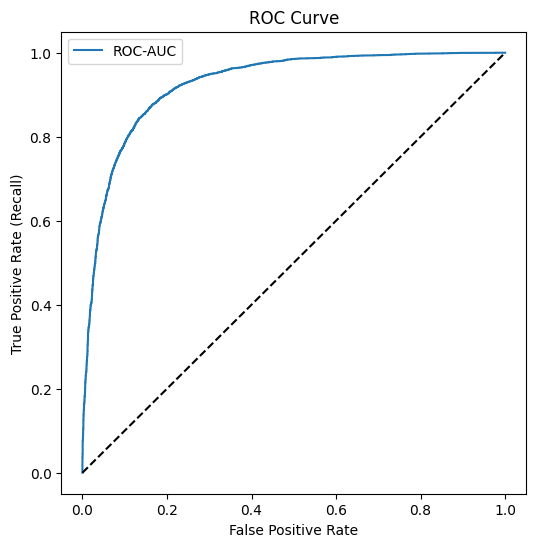

Best threshold (Youden's J): 0.260966


In [175]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(labels, probs)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"ROC-AUC")
plt.plot([0,1], [0,1], 'k--')  # random line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve")
plt.legend()
plt.show()

J = tpr - fpr
ix = np.argmax(J)
best_thresh = thresholds[ix]
print("Best threshold (Youden's J):", best_thresh)


In [9]:
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import cv2
from torchvision import transforms
from PIL import Image

# -----------------------
# Utilities
# -----------------------
def normalize01(x):
    x = x - x.min()
    if x.max() != 0:
        x = x / x.max()
    return x

def pil_from_tensor(tensor):
    return transforms.ToPILImage()(tensor.cpu().clamp(0,1))

# -----------------------
# Grad-CAM generator for ViT (by gradients on ViT patch embeddings)
# -----------------------
def generate_vit_gradcam(model, input_ids, attention_mask, image_tensor, target_class=None, device='cuda'):
    """
    возвращает: cam_map (H,W normalized 0..1), predicted_class, confidence, attn_t2i, attn_i2t
    input_ids, attention_mask: 1D tensors (for single sample)
    image_tensor: 3xHxW tensor (single sample)
    """
    model.eval()
    device = torch.device(device if torch.cuda.is_available() else "cpu")

    # move inputs
    input_ids = input_ids.unsqueeze(0).to(device)          # (1, L)
    attention_mask = attention_mask.unsqueeze(0).to(device)
    image_tensor = image_tensor.unsqueeze(0).to(device)    # (1,3,H,W)

    # --- 1) get text features (no grad needed unless you want grads w.r.t text) ---
    with torch.no_grad():
        text_outputs = model.text_encoder(input_ids=input_ids, attention_mask=attention_mask)
        text_feats = text_outputs.last_hidden_state   # (1, L, D)

    # --- 2) get image features but keep gradients on them ---
    vit_outputs = model.image_encoder(pixel_values=image_tensor)
    img_feats = vit_outputs.last_hidden_state   # (1, P+1, D)
    # make img_feats require grad so gradients flow here
    img_feats = img_feats.detach()
    img_feats.requires_grad_(True)

    # --- 3) run symmetric cross-attention manually using model blocks ---
    # text_to_img: q=text, k=v=img
    # img_to_text: q=img, k=v=text
    # We expect these blocks to return (out, attn_weights)
    text_cross, attn_t2i = model.text_to_img(text_feats, img_feats, img_feats)
    img_cross,  attn_i2t = model.img_to_text(img_feats, text_cross, text_cross, key_padding_mask=(attention_mask==0))  # note: feed updated text_cross for consistency

    # --- 4) pool cross-attended representations ---
    # per your request — use only cross-attended outputs (mean pooling)
    text_emb = text_cross.mean(dim=1)   # (1, D)
    img_emb  = img_cross.mean(dim=1)    # (1, D)

    # --- 5) classification logits (use cross-attended text_emb per design) ---
    logits = model.classifier(text_emb)   # (1, num_classes)
    probs = F.softmax(logits, dim=1)
    pred_class = int(probs.argmax(dim=1).item())
    confidence = float(probs[0, pred_class].item())
    if target_class is None:
        target_class = pred_class

    # --- 6) contrastive projections exist in model but not needed here
    # compute score and backward to get gradients w.r.t img_feats
    score = logits[0, target_class]
    model.zero_grad()
    score.backward(retain_graph=True)

    # --- 7) obtain gradients on img_feats ---
    if img_feats.grad is None:
        # fallback: try to get gradient from img_cross if not propagated to img_feats
        grads = img_cross.grad
    else:
        grads = img_feats.grad    # (1, P+1, D)

    if grads is None:
        raise RuntimeError("Gradients on image features are None — ensure computation graph connects logits to img_feats.")

    # --- 8) compute patch importance: global-average over feature dim D -->
    # grads: (1, P+1, D)  -> avg over D -> (1, P+1)
    weights = grads.mean(dim=-1).squeeze(0).detach().cpu().numpy()   # (P+1,)

    # ignore CLS token (index 0)
    patch_weights = weights[1:]   # (P,)
    patch_weights = np.maximum(patch_weights, 0)
    patch_weights = normalize01(patch_weights)

    # --- 9) reshape to grid ---
    # determine grid size from number of patches
    P = patch_weights.shape[0]
    grid_size = int(np.sqrt(P))
    if grid_size * grid_size != P:
        # try to infer from vit config if available
        try:
            img_size = model.image_encoder.config.image_size
            patch_size = model.image_encoder.config.patch_size
            grid_size = img_size // patch_size
        except Exception:
            raise ValueError(f"Cannot infer grid size for P={P}")
    cam_map = patch_weights.reshape(grid_size, grid_size)   # (g,g)
    # upscale to image size (assume image_tensor size)
    H = image_tensor.shape[-2]
    W = image_tensor.shape[-1]
    cam_up = cv2.resize(cam_map, (W, H))
    cam_up = normalize01(cam_up)

    return cam_up, pred_class, confidence, attn_t2i, attn_i2t, text_feats, img_feats.detach()

# -----------------------
# Attention overlay from text->image: map token -> per-patch scores
# -----------------------
def attention_patch_scores(attn_t2i, token_index=0):
    """
    attn_t2i may be:
      - tensor shape (1, heads, tgt_len_text, src_len_patches)  OR
      - tensor shape (1, tgt_len_text, src_len_patches)
      - or list/tuple per layer (handle common cases)
    We aggregate to get per-patch scores for a chosen token_index.
    Returns normalized per-patch vector length P.
    """
    # convert to tensor and squeeze batch
    if isinstance(attn_t2i, list) or isinstance(attn_t2i, tuple):
        # if list per layer, stack and mean
        attn = torch.stack([a for a in attn_t2i], dim=0)   # (L, B, ...)
    else:
        attn = attn_t2i

    attn = torch.as_tensor(attn)
    attn = attn.squeeze(0)   # drop batch -> shape may be (heads, T, P) or (T, P)
    if attn.ndim == 3:
        # (heads, T, P) -> mean over heads -> (T,P)
        attn2 = attn.mean(dim=0)
    elif attn.ndim == 2:
        attn2 = attn
    else:
        raise ValueError(f"Unexpected attn shape after squeeze: {attn.shape}")

    # attn2: (T, P)
    if token_index is None:
        # aggregate over tokens
        patch_scores = attn2.mean(dim=0).detach().cpu().numpy()
    else:
        patch_scores = attn2[token_index].detach().cpu().numpy()

    patch_scores = np.maximum(patch_scores, 0)
    patch_scores = normalize01(patch_scores)
    return patch_scores  # (P,)

# -----------------------
# Visualization: combine Grad-CAM and attention overlay, show top tokens
# -----------------------
def visualize_multimodal_explanation(model, tokenizer, sample, device='cuda',
                                     top_k_tokens=8, token_index=None, patch_size=16, img_size=224):
    """
    sample: (input_ids, attention_mask, image_tensor, label) from your Dataset
    token_index: if None -> show aggregated attention over tokens; else integer token index to visualize mapping
    """
    input_ids, attention_mask, image_tensor, label = sample
    # run generator
    cam_map, pred_class, conf, attn_t2i, attn_i2t, text_feats, img_feats = generate_vit_gradcam(
        model, input_ids, attention_mask, image_tensor, device=device
    )

    # attention patch scores (from text->image) for the token_index
    # if token_index is None => aggregate over tokens
    # tokenizer.convert_ids_to_tokens for readable tokens
    token_ids = input_ids.cpu().numpy()
    tokens = tokenizer.convert_ids_to_tokens(token_ids)

    # choose token_index: if None -> we'll find top tokens by aggregated attention image->text
    # compute image->text aggregated importance (which tokens receive more attention from patches)
    # attn_i2t shape handling similar to attn_t2i
    # aggregate attn_i2t to per-token importance:
    attn_i2t_tensor = attn_i2t
    if isinstance(attn_i2t_tensor, list) or isinstance(attn_i2t_tensor, tuple):
        attn_i2t_tensor = torch.stack(attn_i2t_tensor, dim=0)
    attn_i2t_tensor = torch.as_tensor(attn_i2t_tensor).squeeze(0)  # (heads, P, T) or (P,T)

    if attn_i2t_tensor.ndim == 3:
        attn_i2t_mean = attn_i2t_tensor.mean(dim=0)   # (P,T)
    else:
        attn_i2t_mean = attn_i2t_tensor  # (P,T)

    # per-token importance: average over patches
    token_importance = attn_i2t_mean.mean(dim=0).detach().cpu().numpy()  # (T,)

    # top tokens
    top_idx = np.argsort(token_importance)[-top_k_tokens:][::-1]
    print("Top tokens by image->text attention (token, score):")
    for idx in top_idx:
        tok = tokens[idx] if idx < len(tokens) else f"tok{idx}"
        print(f"  {idx:3d}: {tok:15s}  {token_importance[idx]:.4f}")

    # If token_index is None, we visualize aggregated attention map (mean over tokens)
    if token_index is None:
        # aggregated text->image attn: get patch scores aggregated over tokens
        patch_scores = attention_patch_scores(attn_t2i, token_index=None)  # (P,)
    else:
        patch_scores = attention_patch_scores(attn_t2i, token_index=token_index)  # (P,)

    # reshape to grid
    P = patch_scores.shape[0]
    patch_scores = patch_scores[1:]
    grid = int(np.sqrt(P))
    patch_map = patch_scores.reshape(grid, grid)
    patch_map_up = cv2.resize(patch_map, (img_size, img_size))
    patch_map_up = normalize01(patch_map_up)

    # combine cam_map and patch_map_up: show side-by-side and blended
    pil_img = pil_from_tensor(image_tensor)
    img_np = np.array(pil_img)

    # gradcam overlay
    heatmap_cam = cv2.applyColorMap(np.uint8(255 * cam_map), cv2.COLORMAP_JET)
    heatmap_cam = cv2.cvtColor(heatmap_cam, cv2.COLOR_BGR2RGB)
    overlay_cam = (0.6 * img_np + 0.4 * heatmap_cam).astype(np.uint8)

    # attention overlay
    heatmap_attn = cv2.applyColorMap(np.uint8(255 * patch_map_up), cv2.COLORMAP_JET)
    heatmap_attn = cv2.cvtColor(heatmap_attn, cv2.COLOR_BGR2RGB)
    overlay_attn = (0.6 * img_np + 0.4 * heatmap_attn).astype(np.uint8)

    # blended combination
    blended = (0.5 * overlay_cam.astype(float) + 0.5 * overlay_attn.astype(float)).astype(np.uint8)

    # Plot
    fig, axes = plt.subplots(1, 4, figsize=(18, 6))
    axes[0].imshow(img_np); axes[0].set_title("Original"); axes[0].axis('off')
    axes[1].imshow(overlay_cam); axes[1].set_title(f"Grad-CAM (pred {pred_class}, conf {conf:.2f})"); axes[1].axis('off')
    axes[2].imshow(overlay_attn); axes[2].set_title("Text->Image attention overlay"); axes[2].axis('off')
    axes[3].imshow(blended); axes[3].set_title("Blended CAM + Attention"); axes[3].axis('off')
    plt.tight_layout()
    plt.show()

    # return maps if needed
    return {
        "cam_map": cam_map,
        "patch_map": patch_map_up,
        "pred_class": pred_class,
        "confidence": conf,
        "top_tokens": [(int(i), tokens[int(i)], float(token_importance[int(i)])) for i in top_idx]
    }


if hillary won
Top tokens by image->text attention (token, score):
    1: if               0.6149
    0: [CLS]            0.2329
    3: won              0.1490
    4: [SEP]            0.0019
    2: hillary          0.0012
   41: [PAD]            0.0000
   46: [PAD]            0.0000
   45: [PAD]            0.0000


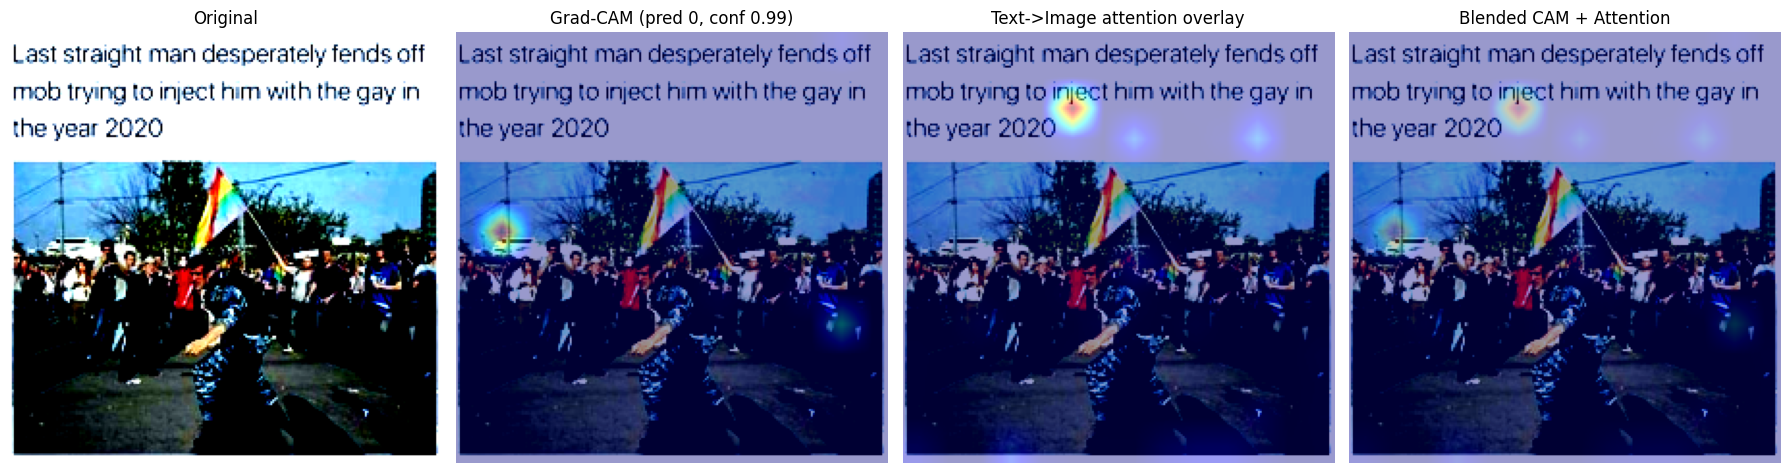

In [113]:
sample = val_set[8199]  # (input_ids, attention_mask, image, label)
input_ids, attention_mask, image, label = sample
decoded_text = tokenizer.decode(input_ids, skip_special_tokens=True)
print(decoded_text)

res = visualize_multimodal_explanation(model, tokenizer, sample, device=device, top_k_tokens=8, token_index=None)

In [82]:
from lime.lime_text import LimeTextExplainer
import torch
import numpy as np
import gc

explainer = LimeTextExplainer(class_names=['real', 'fake'])

def lime_explain_text(sample_text, image_tensor, model, tokenizer, device='cuda', batch_size=8):
    """
    Explain text contribution in a multimodal model (text + fixed image).
    GPU-safe version with batching and cache clearing.
    """
    model.eval()
    device = torch.device(device if torch.cuda.is_available() else "cpu")

    # Prepare image
    image_tensor = image_tensor.unsqueeze(0).to(device)

    @torch.no_grad()
    def wrapped_predict(text_list):
        """
        LIME will call this many times.
        We run it in mini-batches to avoid CUDA OOM.
        """
        probs_all = []

        for i in range(0, len(text_list), batch_size):
            batch_texts = text_list[i:i + batch_size]

            encoding = tokenizer(
                batch_texts,
                padding=True,
                truncation=True,
                max_length=128,
                return_tensors='pt'
            )

            input_ids = encoding['input_ids'].to(device, non_blocking=True)
            attention_mask = encoding['attention_mask'].to(device, non_blocking=True)

            # Repeat image for each text
            images = image_tensor.repeat(len(batch_texts), 1, 1, 1)

            # Forward
            outputs = model(input_ids, attention_mask, images)
            logits = outputs[0] if isinstance(outputs, tuple) else outputs
            probs = torch.softmax(logits, dim=1).detach().cpu().numpy()
            probs_all.append(probs)

            # Free CUDA memory after each batch
            del input_ids, attention_mask, images, outputs, logits
            torch.cuda.empty_cache()
            gc.collect()

        return np.concatenate(probs_all, axis=0)

    # LIME explanation (this still runs on CPU)
    exp = explainer.explain_instance(
        sample_text,
        wrapped_predict,
        num_features=10,
        labels=(0, 1)
    )

    return exp


In [83]:

torch.cuda.empty_cache()

In [ ]:
sample = val_set[8199]  # (input_ids, attention_mask, image, label)
input_ids, attention_mask, image, label = sample
decoded_text = tokenizer.decode(input_ids, skip_special_tokens=True)
explanation = lime_explain_text(decoded_text, image, model, tokenizer)
print(explanation)
print(decoded_text)

if hillary won


In [85]:
explanation.as_map()

{0: [(4, -0.22065754980333627),
  (2, -0.15794514798102277),
  (0, -0.11652906304857641),
  (7, -0.09491165121173485),
  (1, -0.07265812866478027),
  (3, -0.06752740959529528),
  (8, -0.06397693598951569),
  (11, -0.036070271288087534),
  (6, -0.03245023910308014),
  (5, 0.03093696078762385)],
 1: [(4, 0.22065755312871815),
  (2, 0.15794514796487966),
  (0, 0.11652906347496743),
  (7, 0.09491165297436602),
  (1, 0.07265812947181939),
  (3, 0.06752740817236723),
  (8, 0.06397693268705214),
  (11, 0.036070275167080224),
  (6, 0.03245024287584912),
  (5, -0.03093695841373242)]}

In [93]:
explanation.as_html(predict_proba=True)

'<html>\n        <meta http-equiv="content-type" content="text/html; charset=UTF8">\n        <head><script>var lime =\n/******/ (function(modules) { // webpackBootstrap\n/******/ \t// The module cache\n/******/ \tvar installedModules = {};\n/******/\n/******/ \t// The require function\n/******/ \tfunction __webpack_require__(moduleId) {\n/******/\n/******/ \t\t// Check if module is in cache\n/******/ \t\tif(installedModules[moduleId])\n/******/ \t\t\treturn installedModules[moduleId].exports;\n/******/\n/******/ \t\t// Create a new module (and put it into the cache)\n/******/ \t\tvar module = installedModules[moduleId] = {\n/******/ \t\t\texports: {},\n/******/ \t\t\tid: moduleId,\n/******/ \t\t\tloaded: false\n/******/ \t\t};\n/******/\n/******/ \t\t// Execute the module function\n/******/ \t\tmodules[moduleId].call(module.exports, module, module.exports, __webpack_require__);\n/******/\n/******/ \t\t// Flag the module as loaded\n/******/ \t\tmodule.loaded = true;\n/******/\n/******/ 

In [94]:

with open("explanation2.html", "w", encoding="utf-8") as f:
    f.write(explanation.as_html())

In [ ]:
from lime import lime_image
from skimage.segmentation import slic
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
import numpy as np
from PIL import Image
import os
import torch.nn.functional as F
import torch

# -------------------------
# Helper: try to find a good target layer in ViT encoder
# -------------------------
def reshape_transform(tensor, height=14, width=14):
    # Remove CLS token
    result = tensor[:, 1:, :]  
    # Reshape to (B, H, W, C)
    result = result.reshape(result.size(0), height, width, -1)
    # Permute to (B, C, H, W)
    result = result.permute(0, 3, 1, 2)
    return result
# -------------------------
# Wrapper model for GradCAM
# -------------------------
class MultiModalForCAM(nn.Module):
    """
    Обёртка, принимающая на вход только images и возвращающая logits,
    при этом использует фиксированный текст (input_ids, attention_mask).
    Это позволяет grad-cam получить градиенты по слоям image_encoder,
    но считать цель (target) относительно финального logit'а мульти-модальной модели.
    """
    def __init__(self, full_model, fixed_input_ids, fixed_attention_mask):
        super().__init__()
        self.full_model = full_model
        # make sure fixed inputs are detached and on the correct device when used
        self.register_buffer('fixed_input_ids', fixed_input_ids.squeeze(0))
        self.register_buffer('fixed_attention_mask', fixed_attention_mask.squeeze(0))

    def forward(self, images):
        # images: tensor (B, C, H, W)
        # repeat fixed text for batch
        batch_size = images.shape[0]
        input_ids = self.fixed_input_ids.unsqueeze(0).repeat(batch_size, 1)
        attention_mask = self.fixed_attention_mask.unsqueeze(0).repeat(batch_size, 1)
        logits, *_ = self.full_model(input_ids=input_ids, attention_mask=attention_mask, images=images)
        return logits

# -------------------------
# LIME predict wrapper for images (multimodal)
# -------------------------
def make_lime_predict_fn(model, input_ids, attention_mask, transform_val, device):
    """
    Вернёт функцию pred_fn(images_np) -> probs_numpy (N x num_classes).
    images_np: array (N, H, W, 3), dtype uint8 (0..255) (как LIME выдаёт).
    Использует transform_val (PIL->tensor->normalize) и фиксированный текст.
    """
    def pred_fn(images_np):
        model.eval()
        tensors = []
        for im in images_np:
            # im: HWC, uint8
            pil = Image.fromarray(im.astype('uint8'), 'RGB')
            x = transform_val(pil).unsqueeze(0)  # 1, C, H, W
            tensors.append(x)
        batch = torch.cat(tensors, dim=0).to(device)  # (N, C, H, W)
        # prepare text inputs (repeat)
        b = batch.shape[0]
        ids = input_ids.unsqueeze(0).repeat(b,1).to(device)
        mask = attention_mask.unsqueeze(0).repeat(b,1).to(device)
        with torch.no_grad():
            logits, *_ = model(ids, mask, batch)
            probs = torch.softmax(logits, dim=1).cpu().numpy()
        return probs
    return pred_fn

# -------------------------
# Main explain function: runs GradCAM + LIME and plots/saves results
# -------------------------
def explain_image_with_lime_and_gradcam(model, tokenizer,
                                        input_ids, attention_mask, image_tensor,
                                        transform_val,
                                        device='cuda',
                                        lime_samples=200,
                                        top_label=None,
                                        save_path=None):
    """
    input_ids, attention_mask: tensors for the text (1, seq_len) or (seq_len,)
    image_tensor: (C, H, W) tensor (unnormalized? assume already normalized as used by model)
    transform_val: pipeline used in validation (PIL->Tensor->Normalize) for LIME preprocessing
    lime_samples: number of perturbed samples for LIME
    top_label: int or None (if None, use predicted label)
    save_path: если указан, сохраняет картинку
    Возвращает matplotlib.Figure
    """
    model.eval()
    image = image_tensor.clone().detach().to(device)
    # prepare original image in HWC 0..1 for show_cam_on_image
    # undo normalization if transform_val uses Normalize with ImageNet mean/std
    # We'll try to reconstruct 0..1 image from normalized tensor:
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    im_np = image.cpu().numpy().transpose(1,2,0)  # HWC but normalized
    im_01 = (im_np * std + mean).clip(0,1)  # approximate original normalized to 0..1

    # --- GradCAM ---
    # determine a target layer inside ViT
    # target_layer = get_vit_target_layer(model.image_encoder)
    target_layer = model.image_encoder.encoder.layer[-1].output
    # wrap multimodal model for GradCAM
    wrapper = MultiModalForCAM(model, input_ids.unsqueeze(0).to(device), attention_mask.unsqueeze(0).to(device))
    wrapper.to(device)
    # create GradCAM object
    cam = GradCAM(model=wrapper, target_layers=[target_layer], reshape_transform=reshape_transform)
    # input to CAM must be a tensor (B, C, H, W)
    with torch.no_grad():
        inp = image.unsqueeze(0).to(device)
    # optionally compute target category: top_label or predicted
    with torch.no_grad():
        logits, *_ = model(input_ids=input_ids.unsqueeze(0).to(device),
                           attention_mask=attention_mask.unsqueeze(0).to(device),
                           images=inp)
        probs = torch.softmax(logits, dim=1).cpu().numpy()
        pred_label = int(probs.argmax(axis=1)[0])
    target_category = pred_label if top_label is None else int(top_label)

    grayscale_cam = cam(input_tensor=inp, targets=None)[0]  # HxW
    cam_image = show_cam_on_image(im_01, grayscale_cam, use_rgb=True)  # uint8 HxW3

    # --- LIME (image) ---
    explainer = lime_image.LimeImageExplainer()
    predict_fn = make_lime_predict_fn(model, input_ids, attention_mask, transform_val, device)
    # lime wants HWC uint8 0..255
    im_for_lime = (im_01 * 255).astype('uint8')
    # run explain_instance (this is relatively heavy)
    explanation = explainer.explain_instance(
        im_for_lime,
        classifier_fn=predict_fn,
        top_labels=2,
        hide_color=0,
        num_samples=lime_samples,
        segmentation_fn=lambda x: slic(x, n_segments=50, compactness=10)  # faster/better segmentation
    )
    # choose label to visualize
    label_to_vis = target_category
    temp, mask = explanation.get_image_and_mask(label_to_vis,
                                                positive_only=False,
                                                num_features=10,
                                                hide_rest=False)
    # temp: HxWx3 uint8 with highlighted superpixels
    lime_overlay = temp

    # --- plot side-by-side ---
    import matplotlib.pyplot as plt
    fig, axes = plt.subplots(1, 3, figsize=(15,5))
    axes[0].imshow((im_01.clip(0,1)))
    axes[0].set_title('Original (approx)')
    axes[0].axis('off')

    axes[1].imshow(cam_image)
    axes[1].set_title(f'Grad-CAM (pred={pred_label})')
    axes[1].axis('off')

    axes[2].imshow(lime_overlay)
    axes[2].set_title('LIME overlay')
    axes[2].axis('off')

    plt.tight_layout()
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        fig.savefig(save_path, bbox_inches='tight', dpi=200)
    return fig, {'pred_prob': probs[0].tolist(), 'pred_label': pred_label, 'grayscale_cam': grayscale_cam, 'lime_mask': mask}


  0%|          | 0/300 [00:00<?, ?it/s]

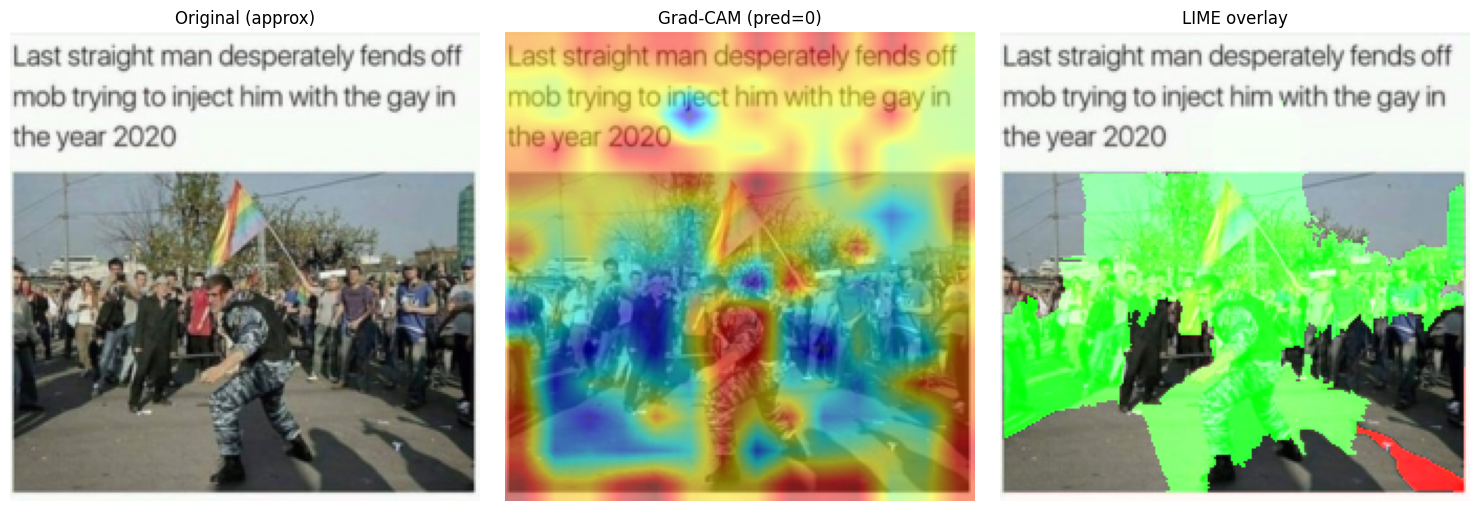

In [112]:
fig, meta = explain_image_with_lime_and_gradcam(model, tokenizer,
                                                input_ids, attention_mask, image,
                                                transform_val, device=device,
                                                lime_samples=300,
                                                save_path='explanations/sample0.png')

plt.show(fig)